In [1]:
import numpy as np
import matplotlib.pylab as plt
import pickle
from scipy import signal
from apis.imaging_classes import save_disp_imgs,bootstrap_disp,VirtualShotGathersFromWindows
from modules.utils import extract_ridge_ref_idx,plot_disp_curves
import random
import scipy
from tqdm.notebook import tqdm

# Load saved surface wave windows associated with vehicle states and speeds

In [2]:
# Define the file name using an f-string to include the value of _x0: pivot.
_x0 = 700
tracking_offset = 150
_start_x = _x0 - tracking_offset
_end_x = _x0 + tracking_offset
file_name = f"data/sw_data/{_x0}.pkl"

# Open the file in binary read mode
with open(file_name, "rb") as f:
    # Load the pickled data from the file.
    windows_all = pickle.load(f)  # Load the 'windows_all' surface wave window data from the file.
    das_veh_states = pickle.load(f)  # Load the 'das_veh_states' data from the file.
    veh_speed = pickle.load(f)  # Load the 'veh_speed' data from the file.

# Get surface wave windows with different vehicle weights

## Use majority vehicle speeds

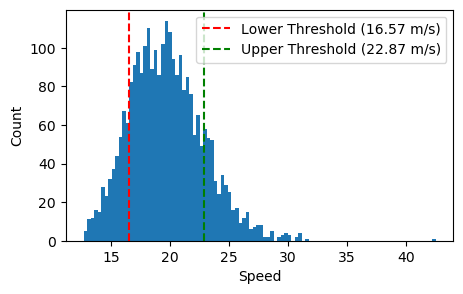

In [3]:
# Define threshold values based on one sigma away from the mode.
lower_limit = np.mean(veh_speed) - 1*np.std(veh_speed)
upper_limit = np.mean(veh_speed) + 1*np.std(veh_speed)
# Define a condition to select speeds within one sigma of the mode.
speed_idx = np.where((veh_speed >= lower_limit) & (veh_speed <= upper_limit))[0]

# Create a histogram of vehicle speeds.
fig = plt.figure(figsize=(5, 3))
plt.hist(veh_speed, bins=100)
plt.xlabel('Speed')
plt.ylabel('Count')
# Plot vertical lines to mark the threshold values.
plt.axvline(lower_limit, color='r', linestyle='--', label=f'Lower Threshold ({lower_limit:.2f} m/s)')
plt.axvline(upper_limit, color='g', linestyle='--', label=f'Upper Threshold ({upper_limit:.2f} m/s)')
# Create a legend to label the threshold lines.
plt.legend()

# Filter das_veh_states_mean and windows_all_rm to only include elements with matching indices in speed_idx.
das_veh_states = [i for j, i in enumerate(das_veh_states) if j in speed_idx]
windows_all = [i for j, i in enumerate(windows_all) if j in speed_idx]

## Spliting small, mid, and large weight vehicles

In [4]:
# Calculate the mean along the first axis
das_veh_states_mean = []
for das_veh in das_veh_states:
    mean_tmp = signal.detrend(signal.savgol_filter(das_veh.mean(0),101,3))
    mean_tmp = mean_tmp-mean_tmp[0]
    das_veh_states_mean.append(mean_tmp)

Number of Heavy Peaks: 91
Number of Mid Peaks: 1033
Number of Small Peaks: 731


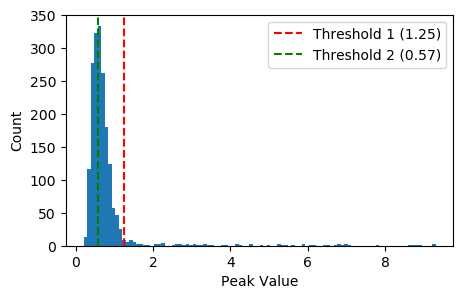

In [5]:
# Calculate the peaks of the mean values.
peaks = np.max(np.abs(das_veh_states_mean), 1)

# Create a histogram of the peaks.
fig = plt.figure(figsize=(5, 3))
n, bins, patches = plt.hist(peaks, bins=100)
plt.xlabel('Peak Value')
plt.ylabel('Count')

# Calculate the mode of the peak values.
mode_peak = bins[np.argmax(n)]
# Define the threshold values.
threshold_1 = 1.25
threshold_2 = mode_peak
# Plot vertical lines to mark the thresholds.
plt.axvline(threshold_1, color='r', linestyle='--', label=f'Threshold 1 ({threshold_1:.2f})')
plt.axvline(threshold_2, color='g', linestyle='--', label=f'Threshold 2 ({threshold_2:.2f})')
# Create a legend to label the threshold lines.
plt.legend()

# Classify peaks into heavy, mid, and small based on the conditions.
heavy_idx = np.where(peaks > threshold_1)[0]
mid_idx = np.where((peaks <= threshold_1) & (peaks > threshold_2))[0]
light_idx = np.where(peaks <= threshold_2)[0]

# Print the number of elements in each category.
print(f'Number of Heavy Peaks: {len(heavy_idx)}')
print(f'Number of Mid Peaks: {len(mid_idx)}')
print(f'Number of Small Peaks: {len(light_idx)}')

In [6]:
windows_heavy = []  # For peaks greater than 2.
windows_mid = []    # For peaks less than or equal to 2 but greater than mode.
windows_light = []  # For peaks smaller than mode.

# Iterate through heavy_idx, mid_idx, and small_idx to collect corresponding surface wave windows.
for k in heavy_idx:
    windows_heavy.append(windows_all[k])
for k in mid_idx:
    windows_mid.append(windows_all[k])
for k in light_idx:
    windows_light.append(windows_all[k])

# Imaging for different weights

## Plot

figures/700/sg_heavy_cars.png has saved...
saving figures/700/disp_heavy_cars_no_norm.png...
saving figures/700/disp_heavy_cars_no_enhance.png...
saving figures/700/disp_heavy_cars.png...
figures/700/sg_mid_cars.png has saved...
saving figures/700/disp_mid_cars_no_norm.png...
saving figures/700/disp_mid_cars_no_enhance.png...
saving figures/700/disp_mid_cars.png...
figures/700/sg_light_cars.png has saved...
saving figures/700/disp_light_cars_no_norm.png...
saving figures/700/disp_light_cars_no_enhance.png...
saving figures/700/disp_light_cars.png...


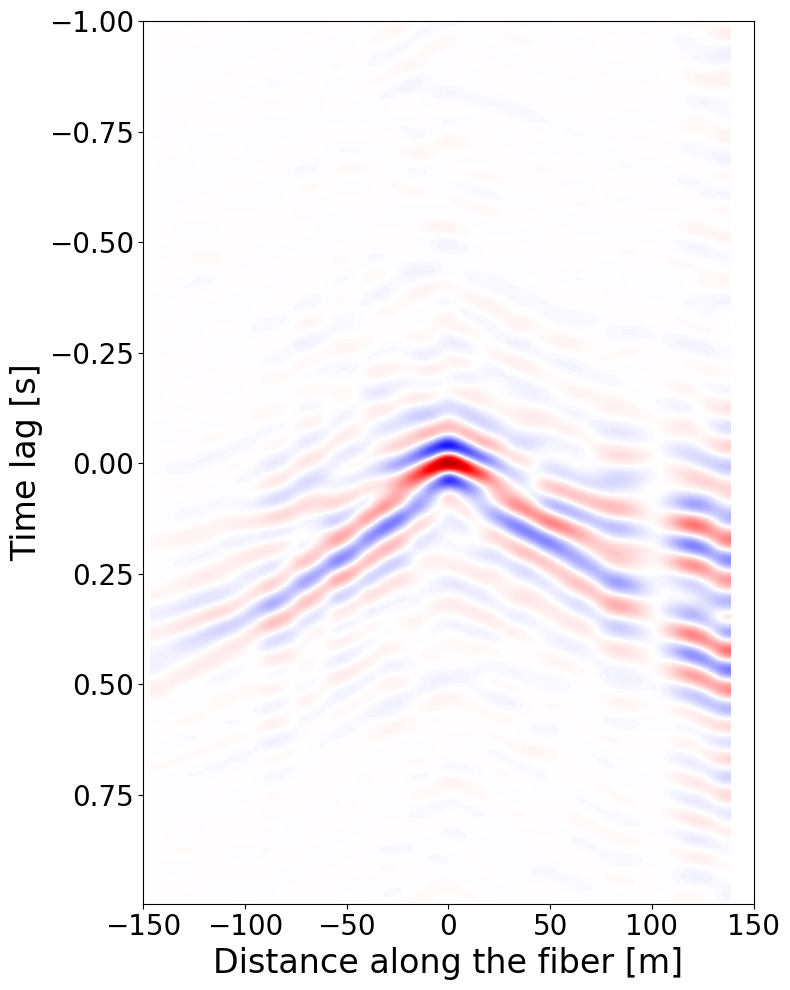

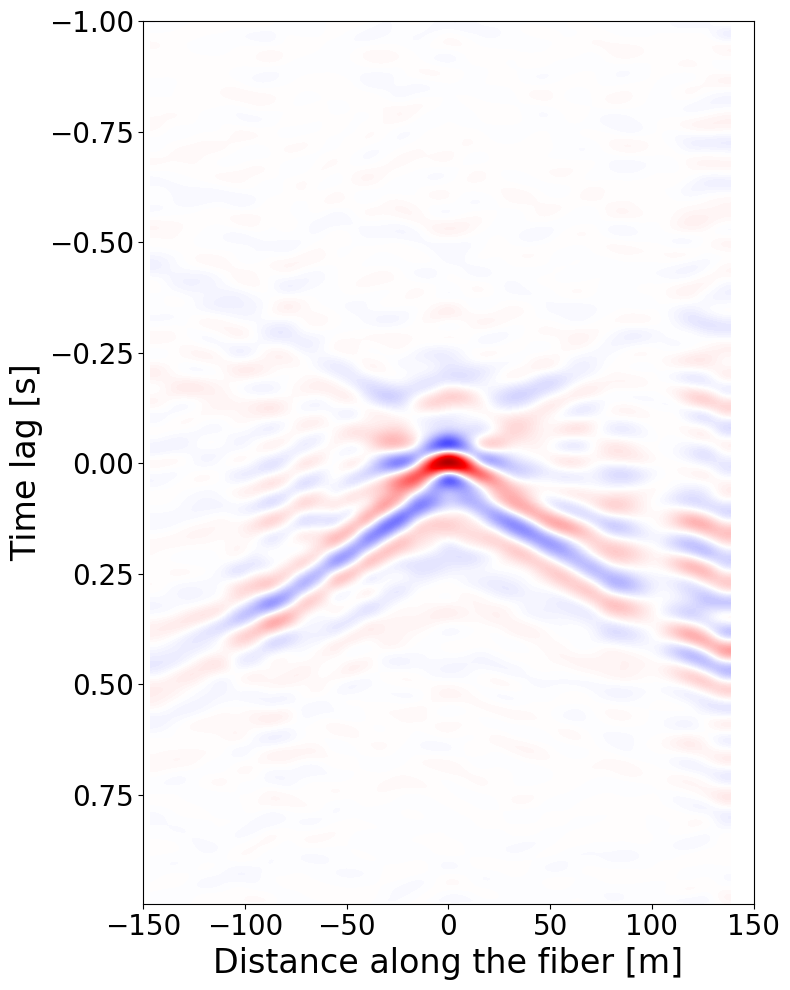

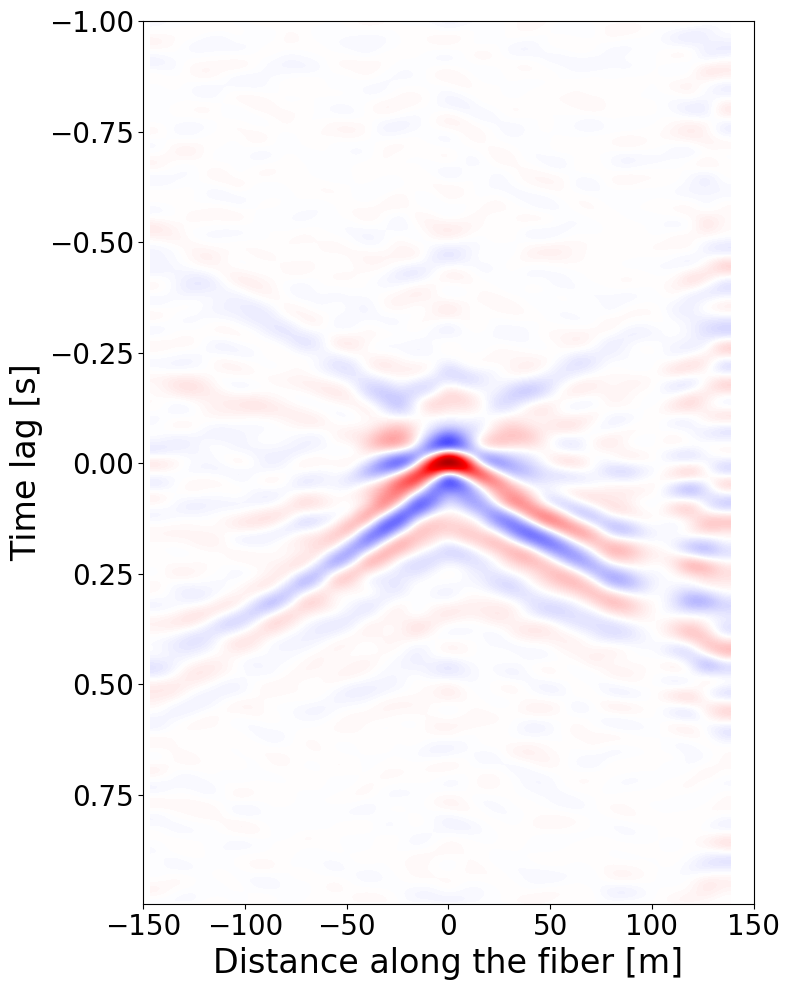

In [7]:
_min_win = np.min([len(heavy_idx),len(mid_idx),len(light_idx)])
images_heavy = save_disp_imgs(windows_heavy, 'heavy', _min_win, _x0, _start_x, _end_x, tracking_offset, fig_dir='figures')
images_mid = save_disp_imgs(windows_mid, 'mid', _min_win, _x0, _start_x, _end_x, tracking_offset, fig_dir='figures')
images_light = save_disp_imgs(windows_light, 'light', _min_win, _x0, _start_x, _end_x, tracking_offset, fig_dir='figures')

## Save image files

In [8]:
# file_name = f'data/saved_disp/{_x0}_images_weights.pkl'
# with open(file_name, 'wb') as file:
#     pickle.dump(images_heavy, file)
#     pickle.dump(images_mid, file)
#     pickle.dump(images_light, file)
#     print(f'Object successfully saved to "{file_name}"')

## Bootstrapping

In [9]:
bt_times = 20
bt_size = 30
sigma = [25,50,50,50]
ref_freq_idx = [80,130,170,170]
freq_lb = [2.5,10,14,16]
freq_ub = [14,16,19,21]
mode1_vel = [530,470,450,430,410,391]
mode1_freq = [10,12,13,14,15,16]
mode1_f = scipy.interpolate.interp1d(mode1_freq, mode1_vel)
mode2_vel = [630,583,550,520,500,490]
mode2_freq = [14,15,16,17,18,19]
mode2_f = scipy.interpolate.interp1d(mode2_freq, mode2_vel)
mode3_vel = [745,690,657,626,600,580]
mode3_freq = [16,17,18,19,20,21]
mode3_f = scipy.interpolate.interp1d(mode3_freq, mode3_vel)
vel_ref = [None,mode1_f,mode2_f,mode3_f]
ridge_vel_light,freqs = bootstrap_disp(windows_light,bt_size,bt_times,sigma,
                                       _x0,_start_x,_end_x,ref_freq_idx,freq_lb,freq_ub,vel_ref)
ridge_vel_heavy,_ = bootstrap_disp(windows_heavy,bt_size,bt_times,sigma,
                                   _x0,_start_x,_end_x,ref_freq_idx,freq_lb,freq_ub,vel_ref)
ridge_vel_mid,_ = bootstrap_disp(windows_mid,bt_size,bt_times,sigma,
                                 _x0,_start_x,_end_x,ref_freq_idx,freq_lb,freq_ub,vel_ref)

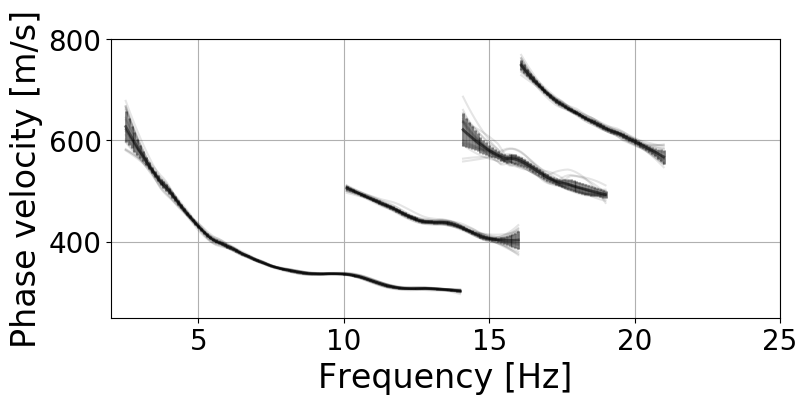

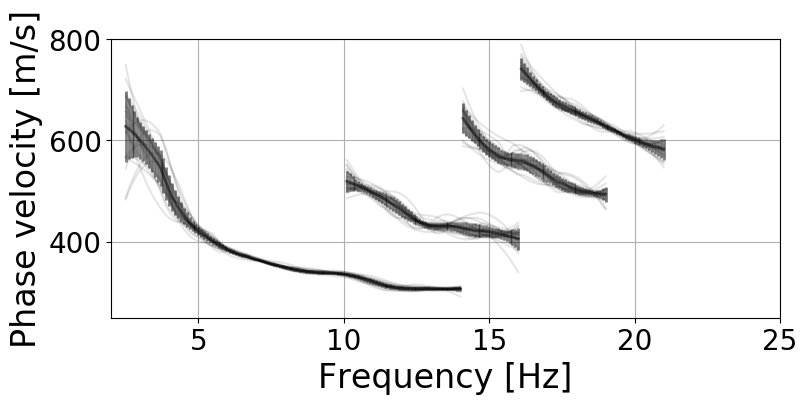

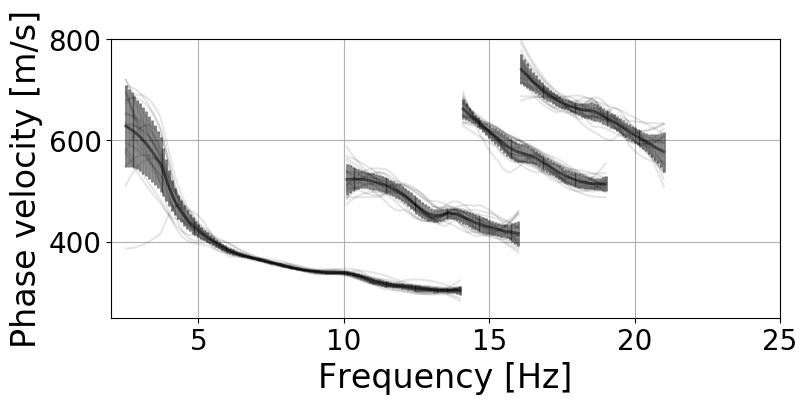

([array([ 628.40586325,  625.03189744,  621.12353735,  616.68078298,
          611.70363434,  606.19209142,  600.14615422,  593.56582274,
          586.45109699,  578.80197696,  570.61846265,  561.90055407,
          552.64825121,  537.18255072,  521.42446377,  506.06595169,
          492.01646377,  479.81406763,  469.31031884,  460.13537198,
          451.83149758,  444.49641546,  437.90229952,  432.14755556,
          426.99279227,  422.16595169,  417.6657971 ,  413.48059903,
          409.3968599 ,  405.26806763,  401.18617391,  397.29182609,
          393.61727536,  390.1165314 ,  386.90503382,  384.1452657 ,
          381.80950725,  379.64732367,  377.43308213,  375.47938164,
          373.8333913 ,  372.33647343,  370.80897585,  369.15019324,
          367.63869565,  366.25478261,  364.88982609,  363.46414493,
          361.93199034,  360.42757488,  359.01813527,  357.69789372,
          356.3909372 ,  355.0112657 ,  353.57784541,  352.2215942 ,
          350.9405314 ,  349.70181

In [10]:
plot_disp_curves(freqs,freq_lb,freq_ub, ridge_vel_heavy)
plot_disp_curves(freqs,freq_lb,freq_ub, ridge_vel_mid)
plot_disp_curves(freqs,freq_lb,freq_ub, ridge_vel_light)

In [11]:
file_name = f'data/{_x0}_weights.npz'
np.savez(file_name, freqs=freqs, freq_lb=freq_lb, freq_ub=freq_ub, 
         vels_heavy=ridge_vel_heavy, 
         vels_mid=ridge_vel_mid, 
         vels_light=ridge_vel_light)

C:\Users\jingx\AppData\Roaming\Python\Python37\site-packages\numpy\lib\npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


## Convergence test

In [12]:
def convergence_test(max_sample_num,windows,bt_times,sigma,
                     x0,start_x,end_x,ref_freq_idx,freq_lb,freq_ub,vel_ref):
    ridge_vel_std = np.empty((len(freq_lb),max_sample_num))
    for bt_size in tqdm(range(1,max_sample_num+1)):
        ridge_vel,freqs = bootstrap_disp(windows,bt_size,bt_times,sigma,x0,start_x,end_x,
                                         ref_freq_idx,freq_lb,freq_ub,vel_ref)
        for mode in range(len(freq_lb)):
            ridge_vel_std[mode,bt_size-1] = np.sum(np.std(ridge_vel[mode],axis=0))
    return ridge_vel_std

In [13]:
bt_sample_num = 50
ridge_vel_heavy_std = convergence_test(bt_sample_num,windows_heavy,bt_times,sigma,
                                 _x0,_start_x,_end_x,ref_freq_idx,freq_lb,freq_ub,vel_ref)
ridge_vel_mid_std = convergence_test(bt_sample_num,windows_mid,bt_times,sigma,
                                 _x0,_start_x,_end_x,ref_freq_idx,freq_lb,freq_ub,vel_ref)
ridge_vel_light_std = convergence_test(bt_sample_num,windows_light,bt_times,sigma,
                                 _x0,_start_x,_end_x,ref_freq_idx,freq_lb,freq_ub,vel_ref)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

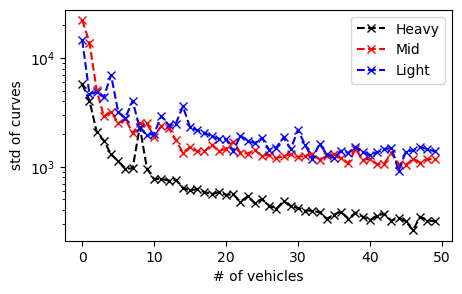

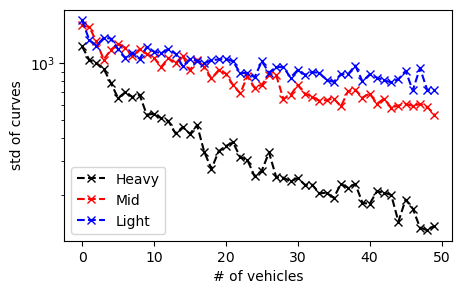

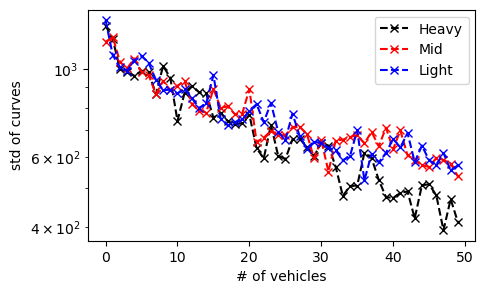

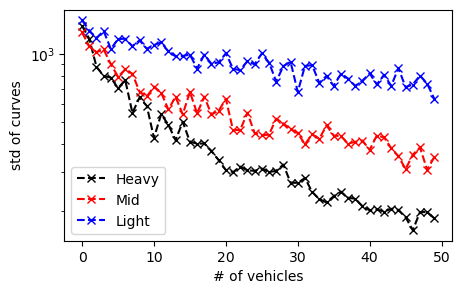

In [14]:
for mode in range(len(freq_lb)):
    plt.figure(figsize=(5,3))
    plt.semilogy(ridge_vel_heavy_std[mode],'x--k',label='Heavy')
    plt.semilogy(ridge_vel_mid_std[mode],'x--r',label='Mid')
    plt.semilogy(ridge_vel_light_std[mode],'x--b',label='Light')
    plt.xlabel('# of vehicles')
    plt.ylabel('std of curves')
#     plt.ylim([])
    plt.legend()